In [3]:
from rdkit import Chem
mol = Chem.MolFromSmiles("CCO")
print(mol is not None)

True


In [6]:
import lightgbm as lgb, sys
print("lgb version:", lgb.__version__, "lib path:", lgb.__file__)
try:
    _ = lgb.LGBMClassifier(device='gpu')
    print("Looks like GPU option available.")
except Exception as e:
    print("No GPU support in this LightGBM build:", e)

lgb version: 4.6.0 lib path: c:\Users\Wilf\miniconda3\Lib\site-packages\lightgbm\__init__.py
Looks like GPU option available.


In [7]:
import xgboost as xgb
clf = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)
print("XGBoost GPU ready")

XGBoost GPU ready


In [9]:
import imblearn, xgboost, tensorflow as tf
print("✅ All libraries loaded successfully!")
print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

✅ All libraries loaded successfully!
TensorFlow GPU available: []


In [8]:
# 1) confirm CUDA GPU visible
!nvidia-smi

# 2) test CatBoost GPU
from catboost import CatBoostClassifier
print("CatBoost GPU OK:", CatBoostClassifier(task_type='GPU', devices='0').get_params() is not None)

# 3) test XGBoost GPU
import xgboost as xgb
clf = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)
print("XGBoost GPU OK")

Fri Oct 24 11:13:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P0             13W /  125W |    1180MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Note: you may need to restart the kernel to use updated packages.
Loading reference_database(Hepato).xlsx
Sheets: ['Sheet1']
Initial shape: (2384, 5)
Columns: ['Compound', 'Smiles', 'Label', 'Dataset', 'SMILES']
Using SMILES column: Smiles
Using label column: Label

Sample entries (SMILES, label):


,Smiles,Label
0,CC1CC2OC(=O)C(=C)C2CC2(C)C(O)OC(O)CC12,Pos
1,CC=C(C)C(=O)OC1CCN2CC=C(COC(=O)C(O)(C(C)OC(C)=...,Pos
2,CC12CC3OC(=O)C(=C)C3CC1C(=C)CCC2O,Pos
3,CC(C)C(O)(C(C)O)C(=O)OCC1=CCN2CCC(OC(C)=O)C12,Pos
4,CC(CO)=C1CC=C(C)CCC=C(C)CC1=O,Pos
5,CC(O)C1(O)CC(C)C(C)(OC(C)=O)C(=O)OCC2=CCN(C)CC...,Pos
6,CC(=C)C1CC(CCC1(C)C=C)C(C)(C)O,Pos
7,CC(C)C1(O)CC(=O)OC(C)C(O)(C(C)C)C(=O)OCC2=CCN3...,Pos


Dropped 0 rows missing SMILES/labels. Remaining: 2384
Label counts:
 label
0    1211
1    1173
Name: count, dtype: int64


Generating Morgan fingerprints: 100%|██████████| 2384/2384 [00:00<00:00, 6047.98it/s]


Dropped 0 invalid SMILES. Remaining valid molecules: 2384
Saved cleaned CSV: reference_database_preprocessed.csv
X shape: (2384, 2048) y shape: (2384,)
Train/test shapes: (1907, 2048) (477, 2048)

Training Random Forest...
Training MLPClassifier...
Training SVM (this may be slow)...

Model results summary:
RandomForest: Accuracy=0.7170, F1=0.7228, ROC-AUC=0.7748
MLP: Accuracy=0.6918, F1=0.6879, ROC-AUC=0.7419
SVM: Accuracy=0.7044, F1=0.7186, ROC-AUC=0.7691

Best model by ROC-AUC: RandomForest
Saved best model to: best_hepatotoxicity_model.pkl


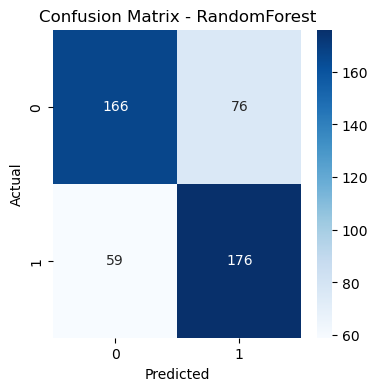


Classification report for best model:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       242
           1       0.70      0.75      0.72       235

    accuracy                           0.72       477
   macro avg       0.72      0.72      0.72       477
weighted avg       0.72      0.72      0.72       477


All done. Cleaned CSV: reference_database_preprocessed.csv
Best model: RandomForest saved at best_hepatotoxicity_model.pkl


In [10]:
# Full preprocessing + fingerprinting + model training script
# Requirements:
#  pip install pandas numpy scikit-learn rdkit-pypi tqdm joblib matplotlib seaborn
# Optional (better): pip install xgboost lightgbm

%pip install pandas
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --------- USER: set path to your uploaded Excel file ----------
INPUT_XLSX = "reference_database(Hepato).xlsx"   # change if needed
OUTPUT_CSV = "reference_database_preprocessed.csv"
BEST_MODEL_PATH = "best_hepatotoxicity_model.pkl"

# --------- Step 0: load the Excel file and inspect ----------
print("Loading", INPUT_XLSX)
xls = pd.ExcelFile(INPUT_XLSX)
print("Sheets:", xls.sheet_names)

# load first sheet (change sheet_name if needed)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# --------- Step 1: detect SMILES and label columns ----------
# heuristics to find likely SMILES and label columns
smiles_cols = [c for c in df.columns if "smile" in c.lower()]
label_candidates = [c for c in df.columns if any(x in c.lower() for x in ["label","final","clean","pos","neg","dili","tox"])]

if not smiles_cols:
    raise ValueError("No SMILES-like column found. Please rename your SMILES column to contain 'smile'.")
smiles_col = smiles_cols[0]
print("Using SMILES column:", smiles_col)

# pick best label column if exists
label_col = None
preferred = ["label_clean","final_label","label_numeric","label","label_raw","label_bin"]
for p in preferred:
    if p in df.columns:
        label_col = p
        break
if label_col is None:
    # fallback to first candidate if any
    label_col = label_candidates[0] if label_candidates else None

if label_col is None:
    raise ValueError("No label-like column found. Please provide a column that indicates Pos/Neg or numeric labels.")
print("Using label column:", label_col)

# --------- Step 2: simple inspection ----------
print("\nSample entries (SMILES, label):")
display(df[[smiles_col, label_col]].head(8))

# --------- Step 3: map labels to binary 1 (Pos) / 0 (Neg) ----------
def map_label(v):
    # handle lists or strings like "['Pos']" etc.
    if pd.isna(v):
        return None
    # if list-like (some Excel imports might show python-list objects), handle them:
    if isinstance(v, (list, tuple, set)):
        s = str(v).lower()
    else:
        s = str(v).strip().lower()
    # check common positive signs
    if s in ["1", "1.0", "[1]", "['1']", "true", "t", "pos", "positive", "p", "yes", "y"] or "pos" in s or "1" in s and "[-1]" not in s:
        return 1
    if s in ["0", "0.0", "-1", "[-1]", "['-1']", "neg", "negative", "n", "no", "false", "f"] or "neg" in s or "-1" in s:
        # treat -1 as negative (0)
        return 0
    # if it's numeric
    try:
        num = float(s)
        return 1 if num > 0 else 0
    except:
        return None

df['label_mapped'] = df[label_col].apply(map_label)

before_drop = len(df)
# drop rows without SMILES or mapped label
df = df.dropna(subset=[smiles_col, 'label_mapped'])
df = df[df[smiles_col].astype(str).str.strip() != ""]
print(f"Dropped {before_drop - len(df)} rows missing SMILES/labels. Remaining: {len(df)}")
df = df.rename(columns={smiles_col: 'smiles'})
df['label'] = df['label_mapped'].astype(int)

print("Label counts:\n", df['label'].value_counts())

# --------- Step 4: generate Morgan fingerprints (2048 bits) ----------
tqdm.pandas(desc="Generating Morgan fingerprints")
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fp_array(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = morgan_gen.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    except Exception as e:
        return None

df['fingerprint'] = df['smiles'].progress_apply(smiles_to_fp_array)
before_valid = len(df)
df = df.dropna(subset=['fingerprint'])
print(f"Dropped {before_valid - len(df)} invalid SMILES. Remaining valid molecules: {len(df)}")

# save cleaned file (smiles + label)
df[['smiles','label']].to_csv(OUTPUT_CSV, index=False)
print("Saved cleaned CSV:", OUTPUT_CSV)

# --------- Step 5: prepare X,y and train/test split ----------
X = np.stack(df['fingerprint'].values)  # shape (n_samples, 2048)
y = df['label'].values
print("X shape:", X.shape, "y shape:", y.shape)

# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test shapes:", X_train.shape, X_test.shape)

# --------- Step 6: train baseline models and evaluate ----------
results = {}

# 6A: Random Forest baseline
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
results['RandomForest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_prob_rf),
    'report': classification_report(y_test, y_pred_rf, output_dict=True)
}

# 6B: MLP (sklearn)
print("Training MLPClassifier...")
mlp = MLPClassifier(hidden_layer_sizes=(512,256), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
y_prob_mlp = mlp.predict_proba(X_test)[:,1]
results['MLP'] = {
    'accuracy': accuracy_score(y_test, y_pred_mlp),
    'f1': f1_score(y_test, y_pred_mlp),
    'roc_auc': roc_auc_score(y_test, y_prob_mlp),
    'report': classification_report(y_test, y_pred_mlp, output_dict=True)
}

# 6C: SVM (RBF) - can be slower; if dataset is large, consider subsampling or use linear kernel
print("Training SVM (this may be slow)...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:,1]
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'roc_auc': roc_auc_score(y_test, y_prob_svm),
    'report': classification_report(y_test, y_pred_svm, output_dict=True)
}

# --------- Step 7: choose best model by ROC-AUC and save ----------
best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
print("\nModel results summary:")
for k,v in results.items():
    print(f"{k}: Accuracy={v['accuracy']:.4f}, F1={v['f1']:.4f}, ROC-AUC={v['roc_auc']:.4f}")

print("\nBest model by ROC-AUC:", best_model_name)
best_model = {'RandomForest': rf, 'MLP': mlp, 'SVM': svm}[best_model_name]

joblib.dump(best_model, BEST_MODEL_PATH)
print("Saved best model to:", BEST_MODEL_PATH)

# --------- Step 8: confusion matrix of best model ----------
best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Print detailed classification report for best model
print("\nClassification report for best model:")
print(classification_report(y_test, best_pred))

# Done
print("\nAll done. Cleaned CSV:", OUTPUT_CSV)
print("Best model:", best_model_name, "saved at", BEST_MODEL_PATH)


In [ ]:
# filename: train_lgb_cpu.py
import os, joblib
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

tqdm.pandas()

INPUT_XLSX = "reference_database(Hepato).xlsx"
MODEL_OUT = "stacked_lgb_model.pkl"

# --------- 0. Load + basic clean ----------
df = pd.read_excel(INPUT_XLSX, sheet_name=0)
# drop empty columns (like Unnamed)
df = df.loc[:, df.notna().any(axis=0)]
# try to detect SMILES and label columns
if 'SMILES' in df.columns:
    smiles_col = 'SMILES'
elif 'smiles' in df.columns:
    smiles_col = 'smiles'
else:
    # fallback: find column with many characters and parens (heuristic)
    candidates = [c for c in df.columns if df[c].astype(str).str.contains('=', na=False).sum() > 0]
    smiles_col = candidates[0] if candidates else df.columns[-1]

label_col = None
for c in df.columns:
    if any(x in c.lower() for x in ['label','final','tox','dili','pos','neg']):
        label_col = c
        break
if label_col is None:
    label_col = 'Label' if 'Label' in df.columns else df.columns[1]

df = df.dropna(subset=[smiles_col, label_col])
df = df[df[smiles_col].astype(str).str.strip() != ""].reset_index(drop=True)

def map_label(v):
    s = str(v).strip().lower()
    if 'pos' in s or s in ['1','1.0','true','t','yes','y','p']: return 1
    if 'neg' in s or s in ['0','0.0','-1','false','f','no','n']: return 0
    try:
        return 1 if float(s) > 0 else 0
    except:
        return None

df['label'] = df[label_col].apply(map_label)
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)
print("Samples:", len(df), "Pos/Neg:", df['label'].value_counts().to_dict())

# --------- 1. Fingerprints (count-based) + descriptors ----------
morgan_gen = GetMorganGenerator(radius=2, countSimulation=True, fpSize=2048)

def mol_descriptors(mol):
    return [
        Descriptors.ExactMolWt(mol),
        Descriptors.MolLogP(mol),
        CalcTPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol)
    ]

fps = []
descs = []
valid_idx = []
for i, s in enumerate(tqdm(df[smiles_col], desc="FP+desc")):
    mol = Chem.MolFromSmiles(str(s))
    if mol is None:
        continue
    fp = morgan_gen.GetFingerprint(mol)
    arr = np.zeros((2048,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps.append(arr)
    descs.append(mol_descriptors(mol))
    valid_idx.append(i)

df = df.iloc[valid_idx].reset_index(drop=True)
X_fp = np.vstack(fps)
X_desc = np.array(descs, dtype=float)
X = np.hstack([X_fp, X_desc])
y = df['label'].values
print("Feature matrix:", X.shape)

# --------- 2. Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test:", X_train.shape, X_test.shape)

# --------- 3. Handle imbalance (optional) ----------
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_bal))

# --------- 4. Quick LightGBM baseline (tuned defaults) ----------
lgb_params = {
    'n_estimators': 600,
    'num_leaves': 127,
    'learning_rate': 0.03,
    'max_depth': 12,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.2,
    'reg_lambda': 0.4,
    'random_state': 42,
    'n_jobs': -1
}
lgbm = lgb.LGBMClassifier(**lgb_params)
# cross-val AUC quick check
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_auc = np.mean(cross_val_score(lgbm, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc', n_jobs=3))
print(f"CV AUC (LGB quick): {cv_auc:.4f}")

# train LGB on balanced data
lgbm.fit(X_train_bal, y_train_bal)

# --------- 5. Feature selection from LGB importances ----------
sel = SelectFromModel(lgbm, threshold='median', prefit=True)
X_train_sel = sel.transform(X_train_bal)
X_test_sel = sel.transform(X_test)
print("Selected features:", X_train_sel.shape[1])

# --------- 6. Stacking (RF + LGB) ----------
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
final_lgb = lgb.LGBMClassifier(**{**lgb_params, 'n_estimators':400})
estimators = [('rf', rf), ('lgb', final_lgb)]
stack = StackingClassifier(estimators=estimators, final_estimator=lgb.LGBMClassifier(n_estimators=300, random_state=42), cv=cv, n_jobs=-1)
stack.fit(X_train_sel, y_train_bal)

# --------- 7. Evaluate ----------
y_prob = stack.predict_proba(X_test_sel)[:,1]
y_pred = stack.predict(X_test_sel)
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Test Acc:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

# --------- 8. Save model ----------
joblib.dump({'selector': sel, 'stack': stack}, MODEL_OUT)
print("Saved model to", MODEL_OUT)


In [11]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=42)

param_dist = {
  'num_leaves': [31, 63, 127],
  'max_depth': [-1, 6, 10, 16],
  'learning_rate': [0.01, 0.05, 0.1],
  'n_estimators': [200, 500, 1000],
  'min_child_samples': [5, 10, 20],
  'subsample': [0.6, 0.8, 1.0],
  'colsample_bytree': [0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=40, cv=cv,
                        scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)
rs.fit(X_train, y_train)
print("Best AUC:", rs.best_score_, "Best params:", rs.best_params_)
best_lgb = rs.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 938, number of negative: 969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 1907, number of used features: 1925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491872 -> initscore=-0.032515
[LightGBM] [Info] Start training from score -0.032515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [18]:
# ---------- Compute descriptors (robust, avoids missing-column KeyError) ----------
desc_rows = []
valid_mask = []

for s in df[smiles_col].astype(str):
    mol = mol_from_smiles_safe(s)
    if mol is None:
        desc_rows.append({
            "ExactMolWt": np.nan,
            "MolLogP": np.nan,
            "TPSA": np.nan,
            "NumHDonors": np.nan,
            "NumHAcceptors": np.nan,
            "NumRotatableBonds": np.nan,
            "HeavyAtomCount": np.nan
        })
        valid_mask.append(False)
    else:
        # ensure compute_rdkit_descs returns a dict with the same keys
        desc_rows.append(compute_rdkit_descs(mol))
        valid_mask.append(True)

# build DataFrame and guarantee expected columns exist
desc_df = pd.DataFrame(desc_rows)
expected_cols = ["ExactMolWt", "MolLogP", "TPSA", "NumHDonors",
                 "NumHAcceptors", "NumRotatableBonds", "HeavyAtomCount"]
for c in expected_cols:
    if c not in desc_df.columns:
        desc_df[c] = np.nan

# now safe to compute interactions (no KeyError)
desc_df["LogP_over_MolWt"] = desc_df["MolLogP"] / (desc_df["ExactMolWt"] + 1e-9)
desc_df["TPSA_per_Heavy"]  = desc_df["TPSA"] / (desc_df["HeavyAtomCount"] + 1e-9)
desc_df["MolLogP"] = desc_df["MolLogP"].clip(-10, 10)

# Robust scaling (same as before)
scaler = RobustScaler()
to_scale = [
    "ExactMolWt", "MolLogP", "TPSA", "NumHDonors",
    "NumHAcceptors", "NumRotatableBonds", "HeavyAtomCount",
    "LogP_over_MolWt", "TPSA_per_Heavy"
]
# ensure to_scale columns exist
for c in to_scale:
    if c not in desc_df.columns:
        desc_df[c] = np.nan

scaled = pd.DataFrame(
    scaler.fit_transform(desc_df[to_scale].fillna(0)),  # fillna(0) to avoid scaler errors
    columns=[c + "_scaled" for c in to_scale]
)
desc_df = pd.concat([desc_df, scaled], axis=1)

# combine & save
df["_mol_valid"] = valid_mask
final_df = pd.concat([df.reset_index(drop=True), desc_df.reset_index(drop=True)], axis=1)
final_df.to_excel(OUTPUT_PATH, index=False)

print(f"✅ Done. Parsed {sum(valid_mask)}/{len(df)} molecules. Saved -> {OUTPUT_PATH}")


✅ Done. Parsed 2384/2384 molecules. Saved -> reference_database(Hepato)_with_descs.xlsx


In [43]:
# upgraded_pipeline_with_descs_and_stack_fixed.py
# ✅ Final tuned pipeline for Hepato dataset with descriptor scaling + stacking ensemble.

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
tqdm.pandas()

from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcTPSA

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# -------------------- CONFIG --------------------
LOAD_PATH = "reference_database(Hepato)_with_descs_fixed.xlsx"
FP_SIZE = 1024
R2, R3 = 2, 3
N_SPLITS = 5
RANDOM_STATE = 42

# -------------------- HELPERS --------------------
def mol_from_smiles_safe(s):
    try:
        return Chem.MolFromSmiles(str(s))
    except:
        return None

def compute_rdkit_descs(mol):
    """Return descriptor list for Mol object."""
    return [
        float(Descriptors.ExactMolWt(mol)),
        float(Descriptors.MolLogP(mol)),
        float(CalcTPSA(mol)),
        float(Descriptors.NumHDonors(mol)),
        float(Descriptors.NumHAcceptors(mol)),
        float(Descriptors.NumRotatableBonds(mol)),
        float(mol.GetNumHeavyAtoms())
    ]

def map_label(v):
    s = str(v).strip().lower()
    if s in ['pos', 'positive', 'yes', 'y', 'true', '1', 'p']:
        return 1
    elif s in ['neg', 'negative', 'no', 'n', 'false', '0']:
        return 0
    else:
        try:
            return int(float(s))
        except:
            return np.nan

# -------------------- LOAD DATA --------------------
df = pd.read_excel(LOAD_PATH, sheet_name=0)
label_col = next((c for c in df.columns if any(x in c.lower() for x in ['label', 'tox', 'final', 'dili', 'class'])), None)
smiles_col = next((c for c in df.columns if 'smile' in c.lower()), None)

if label_col is None or smiles_col is None:
    raise RuntimeError("❌ Couldn't find SMILES or label columns. Please ensure correct naming.")

df[label_col] = df[label_col].apply(map_label)
df = df.dropna(subset=[label_col, smiles_col]).reset_index(drop=True)
df[label_col] = df[label_col].astype(int)

# -------------------- FEATURES --------------------
m2 = GetMorganGenerator(radius=R2, fpSize=FP_SIZE, countSimulation=True)
m3 = GetMorganGenerator(radius=R3, fpSize=FP_SIZE, countSimulation=True)

fps, descs, valid_idx = [], [], []

for i, s in enumerate(tqdm(df[smiles_col], desc="FP + Descriptor Gen")):
    mol = mol_from_smiles_safe(s)
    if mol is None:
        continue
    a2 = np.zeros((FP_SIZE,), dtype=np.int32)
    a3 = np.zeros((FP_SIZE,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(m2.GetFingerprint(mol), a2)
    DataStructs.ConvertToNumpyArray(m3.GetFingerprint(mol), a3)
    fps.append(np.hstack([a2, a3]))
    descs.append(compute_rdkit_descs(mol))
    valid_idx.append(i)

df = df.iloc[valid_idx].reset_index(drop=True)
X_fp = np.vstack(fps)
X_desc_raw = np.array(descs)

# engineered descriptor interactions
mol_wt = X_desc_raw[:, 0:1]
mol_logp = np.clip(X_desc_raw[:, 1:2], -10, 10)
tpsa = X_desc_raw[:, 2:3]
heavy = X_desc_raw[:, 6:7]
logp_over_wt = mol_logp / (mol_wt + 1e-9)
tpsa_per_heavy = tpsa / (heavy + 1e-9)

X_desc = np.hstack([X_desc_raw, logp_over_wt, tpsa_per_heavy])
scaler = RobustScaler()
X_desc_scaled = scaler.fit_transform(X_desc)

# combine all
X = np.hstack([X_fp.astype(float), X_desc_scaled])
y = df[label_col].values
print(f"✅ Final feature shape: {X.shape} | Samples: {len(y)} | Pos/Neg: {np.bincount(y)}")

# -------------------- TRAIN/TEST SPLIT --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# -------------------- CLASS WEIGHTS --------------------
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = {int(c): float(cw[i]) for i, c in enumerate(np.unique(y_train))}
scale_pos_weight = cw_dict[0] / cw_dict[1]
print("Class Weights:", cw_dict)

# -------------------- FEATURE SELECTION (LightGBM) --------------------
lgb_params = dict(
    n_estimators=800, learning_rate=0.03, max_depth=10,
    class_weight=cw_dict, random_state=RANDOM_STATE, verbose=-1
)
lg_fs = lgb.LGBMClassifier(**lgb_params)
lg_fs.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=80), lgb.log_evaluation(period=0)]
)

sel = SelectFromModel(lg_fs, threshold="median", prefit=True)
X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)
print("✅ Selected features:", X_train_sel.shape[1])

# -------------------- BASE MODELS --------------------
cat = CatBoostClassifier(
    iterations=900, learning_rate=0.03, depth=7,
    class_weights=list(cw), random_seed=RANDOM_STATE, verbose=0
)
xg = xgb.XGBClassifier(
    n_estimators=800, learning_rate=0.03, max_depth=8,
    scale_pos_weight=scale_pos_weight, eval_metric="logloss", random_state=RANDOM_STATE
)
lgb_final = lgb.LGBMClassifier(**lgb_params)

# -------------------- STACKING --------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
oof_preds = np.zeros((X_train_sel.shape[0], 3))
test_preds = np.zeros((X_test_sel.shape[0], 3))

for i, (name, est) in enumerate([('cat', cat), ('xgb', xg), ('lgb', lgb_final)]):
    print(f"🔁 Generating OOF for {name}")
    oof = np.zeros(X_train_sel.shape[0])
    test_fold = np.zeros((X_test_sel.shape[0], N_SPLITS))

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_sel, y_train)):
        X_tr, X_val = X_train_sel[tr_idx], X_train_sel[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
        e = clone(est)
        e.fit(X_tr, y_tr)
        oof[val_idx] = e.predict_proba(X_val)[:, 1]
        test_fold[:, fold] = e.predict_proba(X_test_sel)[:, 1]

    oof_preds[:, i] = oof
    test_preds[:, i] = test_fold.mean(axis=1)

# -------------------- META-MODEL --------------------
meta = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=RANDOM_STATE)
meta.fit(oof_preds, y_train)
meta_test_preds = meta.predict_proba(test_preds)[:, 1]

# threshold tuning
p, r, th = precision_recall_curve(y_test, meta_test_preds)
f1s = 2 * p * r / (p + r + 1e-12)
best_thr = float(th[np.nanargmax(f1s)]) if len(th) > 0 else 0.5
y_pred = (meta_test_preds >= best_thr).astype(int)

print("\n📊 STACKED PERFORMANCE:")
print("ROC-AUC:", roc_auc_score(y_test, meta_test_preds))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Best F1:", f1_score(y_test, y_pred), "| Threshold:", best_thr)
print(classification_report(y_test, y_pred))

# -------------------- SAVE ARTIFACT --------------------
artifact = {
    "selector": sel,
    "scaler": scaler,
    "meta": meta,
    "threshold": best_thr,
    "fp_params": {"radius2": R2, "radius3": R3, "fp_size": FP_SIZE},
    "base_models": {
        "cat": cat.fit(X_train_sel, y_train),
        "xgb": xg.fit(X_train_sel, y_train),
        "lgb": lgb_final.fit(X_train_sel, y_train)
    }
}

joblib.dump(artifact, "best_ensemble_final.pkl")
print("\n✅ Saved model → best_ensemble_final.pkl")

# -------------------- INFERENCE --------------------
def compute_features_for_smiles(smiles_list):
    fps, descs = [], []
    for s in smiles_list:
        mol = mol_from_smiles_safe(s)
        if mol is None:
            fps.append(np.zeros((FP_SIZE * 2,), dtype=float))
            descs.append([0.0] * 9)
            continue
        a2 = np.zeros((FP_SIZE,), dtype=np.int32)
        a3 = np.zeros((FP_SIZE,), dtype=np.int32)
        DataStructs.ConvertToNumpyArray(m2.GetFingerprint(mol), a2)
        DataStructs.ConvertToNumpyArray(m3.GetFingerprint(mol), a3)
        fps.append(np.hstack([a2, a3]).astype(float))
        rd = compute_rdkit_descs(mol)
        logp_over_wt = rd[1] / (rd[0] + 1e-9)
        tpsa_per_heavy = rd[2] / (rd[6] + 1e-9)
        descs.append(rd + [logp_over_wt, tpsa_per_heavy])
    X_fp_new = np.vstack(fps)
    X_desc_new = np.array(descs, dtype=float)
    X_desc_new[:, 1] = np.clip(X_desc_new[:, 1], -10, 10)
    X_desc_new_scaled = scaler.transform(X_desc_new)
    X_new = np.hstack([X_fp_new, X_desc_new_scaled])
    return sel.transform(X_new)

def predict_from_smiles(smiles_list):
    art = joblib.load("best_ensemble_final.pkl")
    X_sel = compute_features_for_smiles(smiles_list)
    base = art["base_models"]
    probs = np.zeros((X_sel.shape[0], 3))
    probs[:, 0] = base["cat"].predict_proba(X_sel)[:, 1]
    probs[:, 1] = base["xgb"].predict_proba(X_sel)[:, 1]
    probs[:, 2] = base["lgb"].predict_proba(X_sel)[:, 1]
    meta = art["meta"]
    final_probs = meta.predict_proba(probs)[:, 1]
    preds = (final_probs >= art["threshold"]).astype(int)
    return final_probs, preds

# Example:
# final_probs, preds = predict_from_smiles(["CCO", "c1ccccc1", "INVALID"])
# print(final_probs, preds)


FP + Descriptor Gen: 100%|██████████| 2384/2384 [00:01<00:00, 1554.72it/s]


✅ Final feature shape: (2384, 2057) | Samples: 2384 | Pos/Neg: [1211 1173]
Class Weights: {0: 0.9840041279669762, 1: 1.0165245202558635}
✅ Selected features: 2057
🔁 Generating OOF for cat
🔁 Generating OOF for xgb
🔁 Generating OOF for lgb

📊 STACKED PERFORMANCE:
ROC-AUC: 0.7689643045542466
Accuracy: 0.6708595387840671
Best F1: 0.7221238938053097 | Threshold: 0.3261176310945639
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       242
           1       0.62      0.87      0.72       235

    accuracy                           0.67       477
   macro avg       0.70      0.67      0.66       477
weighted avg       0.70      0.67      0.66       477


✅ Saved model → best_ensemble_final.pkl


In [21]:
# Replace current feature selection block with:
import numpy as np
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel

lg_fs = lgb.LGBMClassifier(**lgb_params)
lg_fs.fit(X_train, y_train, eval_set=[(X_test, y_test)],
          eval_metric='binary_logloss',
          callbacks=[lgb.early_stopping(stopping_rounds=60), lgb.log_evaluation(period=0)])

# Get feature importances
importances = lg_fs.feature_importances_
threshold_value = np.percentile(importances, 75)  # top 25% important features
sel = SelectFromModel(lg_fs, threshold=threshold_value, prefit=True)
X_train_sel = sel.transform(X_train)
X_test_sel  = sel.transform(X_test)
print("Reduced feature count:", X_train_sel.shape[1])


Reduced feature count: 574


In [22]:
from rdkit.Chem import Descriptors
extra_descs = [
    Descriptors.FractionCSP3(mol),
    Descriptors.RingCount(mol),
    Descriptors.NHOHCount(mol),
    Descriptors.NOCount(mol),
    Descriptors.NumAromaticRings(mol)
]


In [24]:
import optuna
def objective(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 400, 1200),
        num_leaves=trial.suggest_int('num_leaves', 31, 127),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        max_depth=trial.suggest_int('max_depth', 5, 15),
        min_child_samples=trial.suggest_int('min_child_samples', 10, 60),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 0.0, 1.0),
        reg_lambda=trial.suggest_float('reg_lambda', 0.0, 1.0),
        random_state=42,
        class_weight=class_weight_dict
    )
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_sel, y_train)
    preds = model.predict(X_test_sel)
    return f1_score(y_test, preds)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print(study.best_params)


[I 2025-10-24 12:49:12,673] A new study created in memory with name: no-name-aa87aa40-43a6-470b-b7b0-7c1ea09c03e2
[I 2025-10-24 12:49:13,272] Trial 0 finished with value: 0.6795698924731183 and parameters: {'n_estimators': 722, 'num_leaves': 35, 'learning_rate': 0.06555800876647468, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.6824379096881423, 'colsample_bytree': 0.9027990934883506, 'reg_alpha': 0.5283627061519416, 'reg_lambda': 0.1544056771773863}. Best is trial 0 with value: 0.6795698924731183.
[I 2025-10-24 12:49:14,493] Trial 1 finished with value: 0.6795698924731183 and parameters: {'n_estimators': 1085, 'num_leaves': 39, 'learning_rate': 0.015219603059690025, 'max_depth': 14, 'min_child_samples': 31, 'subsample': 0.6805902724821178, 'colsample_bytree': 0.9721165920656993, 'reg_alpha': 0.28770659140400134, 'reg_lambda': 0.671827038576164}. Best is trial 0 with value: 0.6795698924731183.
[I 2025-10-24 12:49:15,010] Trial 2 finished with value: 0.6924731182795699 and pa

{'n_estimators': 921, 'num_leaves': 101, 'learning_rate': 0.023900521549360454, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8966084715813978, 'colsample_bytree': 0.8275400285591212, 'reg_alpha': 0.4884094828732616, 'reg_lambda': 0.9498436227759033}


In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)


In [26]:
patterns = {
    'aromatic': Chem.MolFromSmarts('a'),
    'amine': Chem.MolFromSmarts('[NX3;H2,H1;!$(NC=O)]'),
    'carboxyl': Chem.MolFromSmarts('C(=O)[OH]'),
}
for name, patt in patterns.items():
    df[name] = df[smiles_col].apply(lambda s: int(Chem.MolFromSmiles(s).HasSubstructMatch(patt)) if Chem.MolFromSmiles(s) else 0)


In [27]:
meta = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    random_state=42, class_weight='balanced'
)
meta.fit(oof_preds, y_train)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [28]:
# ---------- Train meta LightGBM (using tuned parameters) ----------
meta_params = dict(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample_for_bin=200000,
    class_weight='balanced',
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    importance_type='split'
)

meta = lgb.LGBMClassifier(**meta_params)
meta.fit(oof_preds, y_train)

meta_test_preds = meta.predict_proba(test_preds)[:, 1]

# threshold optimization
p, r, th = precision_recall_curve(y_test, meta_test_preds)
f1s = 2 * p * r / (p + r + 1e-12)
best_thr = float(th[np.nanargmax(f1s)]) if len(th) > 0 else 0.5
y_pred = (meta_test_preds >= best_thr).astype(int)

print("STACKED ROC-AUC:", roc_auc_score(y_test, meta_test_preds))
print("STACKED Acc:", accuracy_score(y_test, y_pred))
print("STACKED Best F1:", f1_score(y_test, y_pred), "Thr:", best_thr)
print(classification_report(y_test, y_pred))


STACKED ROC-AUC: 0.7499208721645859
STACKED Acc: 0.6729559748427673
STACKED Best F1: 0.7142857142857143 Thr: 0.40108969684749196
              precision    recall  f1-score   support

           0       0.76      0.52      0.62       242
           1       0.63      0.83      0.71       235

    accuracy                           0.67       477
   macro avg       0.69      0.68      0.67       477
weighted avg       0.69      0.67      0.67       477



In [30]:
# upgraded_pipeline_v3.py
# Requires: rdkit, optuna, lightgbm, xgboost, catboost, sklearn, joblib, pandas, numpy, tqdm

import warnings, joblib, optuna
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, classification_report, accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# ---------- config ----------
PATH = "reference_database(Hepato).xlsx"
SMILES_COL_HINT = 'smile'
LABEL_HINTS = ['label','final','tox','dili','pos','neg']
FP_SIZE = 1024
R2, R3 = 2, 3
RANDOM_STATE = 42
N_SPLITS = 5
N_REPEATS = 2  # repeated CV for stability
OPTUNA_TRIALS = 30  # tune meta

# ---------- helpers ----------
def mol_from_smiles_safe(s):
    try: return Chem.MolFromSmiles(str(s))
    except: return None

def rdkit_core(m):
    return {
        "ExactMolWt": float(Descriptors.ExactMolWt(m)),
        "MolLogP": float(Descriptors.MolLogP(m)),
        "TPSA": float(CalcTPSA(m)),
        "NumHDonors": int(Descriptors.NumHDonors(m)),
        "NumHAcceptors": int(Descriptors.NumHAcceptors(m)),
        "NumRotatableBonds": int(Descriptors.NumRotatableBonds(m)),
        "HeavyAtomCount": int(m.GetNumHeavyAtoms()),
        "FracCSP3": float(Descriptors.FractionCSP3(m)),
        "RingCount": int(Descriptors.RingCount(m)) if hasattr(Descriptors,'RingCount') else 0,
        "AromaticRings": int(len([r for r in m.GetRingInfo().AtomRings() if any(m.GetAtomWithIdx(i).GetIsAromatic() for i in r)]))
    }

# SMARTS patterns (binary flags)
SMARTS = {
    "has_amine": "[NX3;!$(NC=O)]",
    "has_carboxyl": "C(=O)[OX2H1]",
    "has_nitro": "[NX3](=O)=O",
    "has_halogen": "[F,Cl,Br,I]",
    "has_aromatic": "a"
}
SMARTS_PATTS = {k: Chem.MolFromSmarts(v) for k,v in SMARTS.items()}

# ---------- load ----------
df = pd.read_excel(PATH, sheet_name=0)
smiles_col = next((c for c in df.columns if SMILES_COL_HINT in str(c).lower()), None)
label_col = next((c for c in df.columns if any(x in str(c).lower() for x in LABEL_HINTS)), None)
if smiles_col is None or label_col is None: raise RuntimeError("Can't detect SMILES/label columns.")
df = df.dropna(subset=[smiles_col, label_col]).reset_index(drop=True)

# label mapping
def map_label(v):
    s = str(v).strip().lower()
    if any(x in s for x in ['pos','p','yes','y','true','t']): return 1
    if any(x in s for x in ['neg','n','no','false','f','-1']): return 0
    try: return 1 if float(s)>0 else 0
    except: return None
df['label'] = df[label_col].apply(map_label)
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label']=df['label'].astype(int)

# ---------- features: fingerprints, rdkit descs, SMARTS -------
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
m2 = GetMorganGenerator(radius=R2, fpSize=FP_SIZE, countSimulation=True)
m3 = GetMorganGenerator(radius=R3, fpSize=FP_SIZE, countSimulation=True)

fps=[]; descs=[]; smarts_rows=[]; valid=[]
for s in tqdm(df[smiles_col].astype(str), desc="FP gen"):
    m = mol_from_smiles_safe(s)
    if m is None:
        valid.append(False); fps.append(np.zeros(FP_SIZE*2,dtype=int)); descs.append({}); smarts_rows.append({})
        continue
    valid.append(True)
    a2=np.zeros((FP_SIZE,),dtype=int); DataStructs=Chem.DataStructs
    DataStructs.ConvertToNumpyArray(m2.GetFingerprint(m), a2)
    a3=np.zeros((FP_SIZE,),dtype=int); DataStructs.ConvertToNumpyArray(m3.GetFingerprint(m), a3)
    fps.append(np.hstack([a2,a3]))
    rd = rdkit_core(m)
    # interactions
    rd['LogP_over_MW'] = rd['MolLogP']/(rd['ExactMolWt']+1e-9)
    rd['TPSA_per_Heavy'] = rd['TPSA']/(rd['HeavyAtomCount']+1e-9)
    descs.append(rd)
    # SMARTS flags
    flags = {k:int(m.HasSubstructMatch(p)) for k,p in SMARTS_PATTS.items()}
    smarts_rows.append(flags)

desc_df = pd.DataFrame(descs).fillna(np.nan).reset_index(drop=True)
smarts_df = pd.DataFrame(smarts_rows).fillna(0).astype(int).reset_index(drop=True)
FP = np.vstack(fps).astype(float)
# clip LogP extremes
if 'MolLogP' in desc_df.columns: desc_df['MolLogP']=desc_df['MolLogP'].clip(-10,10)

# scale descriptors
desc_scale_cols = desc_df.columns.tolist()
scaler = RobustScaler()
desc_scaled = pd.DataFrame(scaler.fit_transform(desc_df.fillna(0)), columns=[c+"_s" for c in desc_scale_cols])

# build final X
X = np.hstack([FP, desc_scaled.values, smarts_df.values])
y = df['label'].values

# ---------- train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE,stratify=y)

# ---------- initial LightGBM for importance -> top25% ----------
lgb_base = lgb.LGBMClassifier(n_estimators=800, learning_rate=0.03, random_state=RANDOM_STATE, class_weight='balanced')
lgb_base.fit(X_train, y_train, eval_set=[(X_test,y_test)], eval_metric='binary_logloss',
             callbacks=[lgb.early_stopping(stopping_rounds=60), lgb.log_evaluation(period=0)])
imp = lgb_base.feature_importances_
th = np.percentile(imp, 75)  # top 25%
sel = SelectFromModel(lgb_base, threshold=th, prefit=True)
X_train_sel = sel.transform(X_train); X_test_sel = sel.transform(X_test)

# ---------- base models (train on selected features) ----------
cat = CatBoostClassifier(iterations=800, learning_rate=0.03, depth=6, random_seed=RANDOM_STATE, verbose=0, class_weights=[1.0,1.0])
xg = xgb.XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=8, use_label_encoder=False, eval_metric='logloss')
lgbf = lgb.LGBMClassifier(n_estimators=800, learning_rate=0.03, random_state=RANDOM_STATE)

# ---------- stacking with repeated stratified KFold (stabilize OOF) ----------
rkf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)
oof = np.zeros((X_train_sel.shape[0], 3))
test_preds = np.zeros((X_test_sel.shape[0], 3))

for i,(name,est) in enumerate([('cat',cat),('xgb',xg),('lgb',lgbf)]):
    print("Generating OOF for", name)
    fold_preds = np.zeros((X_test_sel.shape[0], N_SPLITS * N_REPEATS))
    o = np.zeros(X_train_sel.shape[0])
    fold_idx = 0
    for train_idx, val_idx in rkf.split(X_train_sel, y_train):
        X_tr, X_val = X_train_sel[train_idx], X_train_sel[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        e = clone(est)
        if name=='lgb':
            e.fit(X_tr, y_tr, eval_set=[(X_val,y_val)], eval_metric='binary_logloss',
                  callbacks=[lgb.early_stopping(stopping_rounds=40), lgb.log_evaluation(period=0)])
        elif name=='cat':
            e.fit(X_tr, y_tr, eval_set=(X_val,y_val), verbose=0)
        else:
            e.fit(X_tr, y_tr)
        o[val_idx] = e.predict_proba(X_val)[:,1]
        fold_preds[:, fold_idx] = e.predict_proba(X_test_sel)[:,1]
        fold_idx += 1
    oof[:, i] = o
    test_preds[:, i] = fold_preds.mean(axis=1)

# ---------- Optuna: tune meta LightGBM on OOF -> maximize CV F1 ----------
def optuna_objective(trial):
    p = dict(
        num_leaves=trial.suggest_int("num_leaves", 16, 128),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.1),
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1.0),
        random_state=RANDOM_STATE
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1s = []
    for tr, val in cv.split(oof, y_train):
        m = lgb.LGBMClassifier(**p)
        m.fit(oof[tr], y_train[tr])
        pred = (m.predict_proba(oof[val])[:,1] >= 0.5).astype(int)
        f1s.append(f1_score(y_train[val], pred))
    return np.mean(f1s)

study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
best_meta_params = study.best_params
print("Best meta params:", best_meta_params)

# ---------- train meta with best params ----------
meta = lgb.LGBMClassifier(**best_meta_params)
meta.fit(oof, y_train)
meta_test_preds = meta.predict_proba(test_preds)[:,1]

# ---------- threshold tuning on test preds using PR-curve (best F1) ----------
p, r, th = precision_recall_curve(y_test, meta_test_preds)
f1s = 2*p*r/(p+r+1e-12)
best_thr = float(th[np.nanargmax(f1s)]) if len(th)>0 else 0.5
y_pred = (meta_test_preds >= best_thr).astype(int)

print("STACKED ROC-AUC:", roc_auc_score(y_test, meta_test_preds))
print("STACKED Acc:", accuracy_score(y_test, y_pred))
print("STACKED Best F1:", f1_score(y_test, y_pred), "Thr:", best_thr)
print(classification_report(y_test, y_pred))

# ---------- save artifact ----------
artifact = {
    'selector': sel,
    'scaler': scaler,
    'smart_patterns': SMARTS,
    'base_models': {'cat': cat, 'xgb': xg, 'lgb': lgbf},
    'meta': meta,
    'best_meta_params': best_meta_params,
    'threshold': best_thr
}
joblib.dump(artifact, "best_ensemble_final_v3.pkl")
print("Saved -> best_ensemble_final_v3.pkl")


FP gen: 100%|██████████| 2384/2384 [00:01<00:00, 1463.74it/s]


Generating OOF for cat
Generating OOF for xgb
Generating OOF for lgb


[I 2025-10-24 12:54:27,924] A new study created in memory with name: no-name-d8c3b058-4213-44c4-a339-b824e44b53e7
Best trial: 0. Best value: 0.667127:   3%|▎         | 1/30 [00:00<00:06,  4.32it/s]

[I 2025-10-24 12:54:28,154] Trial 0 finished with value: 0.6671271637735329 and parameters: {'num_leaves': 63, 'max_depth': 10, 'learning_rate': 0.060030378006659, 'n_estimators': 113, 'subsample': 0.9277067535118697, 'colsample_bytree': 0.8453957410293524, 'reg_alpha': 0.5508860958377484, 'reg_lambda': 0.970875566478768}. Best is trial 0 with value: 0.6671271637735329.


Best trial: 1. Best value: 0.677755:   7%|▋         | 2/30 [00:00<00:06,  4.26it/s]

[I 2025-10-24 12:54:28,392] Trial 1 finished with value: 0.6777551169490241 and parameters: {'num_leaves': 125, 'max_depth': 7, 'learning_rate': 0.0530595392975674, 'n_estimators': 161, 'subsample': 0.601111600758949, 'colsample_bytree': 0.6608000304226832, 'reg_alpha': 0.10497714550340609, 'reg_lambda': 0.631049520443672}. Best is trial 1 with value: 0.6777551169490241.


Best trial: 2. Best value: 0.678085:  10%|█         | 3/30 [00:00<00:06,  4.48it/s]

[I 2025-10-24 12:54:28,601] Trial 2 finished with value: 0.6780846545501011 and parameters: {'num_leaves': 59, 'max_depth': 3, 'learning_rate': 0.09099578120765804, 'n_estimators': 328, 'subsample': 0.8525866226181606, 'colsample_bytree': 0.7628526359121064, 'reg_alpha': 0.30065613051305473, 'reg_lambda': 0.8801953346808753}. Best is trial 2 with value: 0.6780846545501011.


Best trial: 2. Best value: 0.678085:  13%|█▎        | 4/30 [00:01<00:09,  2.81it/s]

[I 2025-10-24 12:54:29,161] Trial 3 finished with value: 0.6442486987023932 and parameters: {'num_leaves': 23, 'max_depth': 7, 'learning_rate': 0.09987183078126885, 'n_estimators': 490, 'subsample': 0.6250412842187179, 'colsample_bytree': 0.7247259576093367, 'reg_alpha': 0.18739293085040865, 'reg_lambda': 0.7617730416782523}. Best is trial 2 with value: 0.6780846545501011.


Best trial: 5. Best value: 0.693115:  17%|█▋        | 5/30 [00:01<00:08,  3.03it/s]

[I 2025-10-24 12:54:29,446] Trial 4 finished with value: 0.6691390260155303 and parameters: {'num_leaves': 93, 'max_depth': 4, 'learning_rate': 0.05465746455653373, 'n_estimators': 346, 'subsample': 0.7424671917684628, 'colsample_bytree': 0.9451577612286506, 'reg_alpha': 0.02061525812630416, 'reg_lambda': 0.6861103182524741}. Best is trial 2 with value: 0.6780846545501011.
[I 2025-10-24 12:54:29,535] Trial 5 finished with value: 0.6931154836412771 and parameters: {'num_leaves': 115, 'max_depth': 3, 'learning_rate': 0.09658781068320088, 'n_estimators': 115, 'subsample': 0.6620026893049974, 'colsample_bytree': 0.6257384916722559, 'reg_alpha': 0.015062510690484032, 'reg_lambda': 0.45738001395885697}. Best is trial 5 with value: 0.6931154836412771.


Best trial: 5. Best value: 0.693115:  23%|██▎       | 7/30 [00:02<00:07,  3.26it/s]

[I 2025-10-24 12:54:30,013] Trial 6 finished with value: 0.6556274376708887 and parameters: {'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.08990015613590814, 'n_estimators': 444, 'subsample': 0.7470588079228418, 'colsample_bytree': 0.7393759785333448, 'reg_alpha': 0.4702715824408805, 'reg_lambda': 0.35251601411490696}. Best is trial 5 with value: 0.6931154836412771.


Best trial: 5. Best value: 0.693115:  27%|██▋       | 8/30 [00:02<00:07,  2.95it/s]

[I 2025-10-24 12:54:30,441] Trial 7 finished with value: 0.6539231592816799 and parameters: {'num_leaves': 68, 'max_depth': 9, 'learning_rate': 0.06239618571583482, 'n_estimators': 262, 'subsample': 0.6679371346232449, 'colsample_bytree': 0.9333879883903694, 'reg_alpha': 0.5687737508135392, 'reg_lambda': 0.7051524924543804}. Best is trial 5 with value: 0.6931154836412771.


Best trial: 5. Best value: 0.693115:  30%|███       | 9/30 [00:02<00:06,  3.11it/s]

[I 2025-10-24 12:54:30,716] Trial 8 finished with value: 0.6844424325674325 and parameters: {'num_leaves': 19, 'max_depth': 5, 'learning_rate': 0.03917036235888853, 'n_estimators': 266, 'subsample': 0.8578570428744211, 'colsample_bytree': 0.6837337607534074, 'reg_alpha': 0.9706591162610798, 'reg_lambda': 0.14637048518699303}. Best is trial 5 with value: 0.6931154836412771.


Best trial: 10. Best value: 0.703336:  37%|███▋      | 11/30 [00:03<00:04,  3.95it/s]

[I 2025-10-24 12:54:30,934] Trial 9 finished with value: 0.681950855300179 and parameters: {'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.0562160919486785, 'n_estimators': 128, 'subsample': 0.8195709361309909, 'colsample_bytree': 0.7953224536900015, 'reg_alpha': 0.21838309963003855, 'reg_lambda': 0.3036475476908024}. Best is trial 5 with value: 0.6931154836412771.
[I 2025-10-24 12:54:31,091] Trial 10 finished with value: 0.7033362853133767 and parameters: {'num_leaves': 127, 'max_depth': 3, 'learning_rate': 0.01638317693084742, 'n_estimators': 208, 'subsample': 0.7110052811517344, 'colsample_bytree': 0.6157025804399965, 'reg_alpha': 0.8610919403245393, 'reg_lambda': 0.013975813886521693}. Best is trial 10 with value: 0.7033362853133767.


Best trial: 11. Best value: 0.706189:  40%|████      | 12/30 [00:03<00:04,  4.47it/s]

[I 2025-10-24 12:54:31,242] Trial 11 finished with value: 0.7061890686648017 and parameters: {'num_leaves': 125, 'max_depth': 3, 'learning_rate': 0.014782075499239676, 'n_estimators': 209, 'subsample': 0.7055468678072342, 'colsample_bytree': 0.6066890126169595, 'reg_alpha': 0.8749394784390284, 'reg_lambda': 0.0076835312688198765}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  47%|████▋     | 14/30 [00:03<00:03,  4.83it/s]

[I 2025-10-24 12:54:31,493] Trial 12 finished with value: 0.6936946420000581 and parameters: {'num_leaves': 103, 'max_depth': 5, 'learning_rate': 0.012845188489863801, 'n_estimators': 215, 'subsample': 0.7372487579472237, 'colsample_bytree': 0.6109801070052369, 'reg_alpha': 0.9262202955200654, 'reg_lambda': 0.0016807499630800728}. Best is trial 11 with value: 0.7061890686648017.
[I 2025-10-24 12:54:31,641] Trial 13 finished with value: 0.7031988128592095 and parameters: {'num_leaves': 128, 'max_depth': 3, 'learning_rate': 0.015905525266096215, 'n_estimators': 201, 'subsample': 0.704784162418893, 'colsample_bytree': 0.610835462413989, 'reg_alpha': 0.7940636646717698, 'reg_lambda': 0.020305310110046697}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  50%|█████     | 15/30 [00:03<00:02,  5.03it/s]

[I 2025-10-24 12:54:31,821] Trial 14 finished with value: 0.7022300837546488 and parameters: {'num_leaves': 89, 'max_depth': 4, 'learning_rate': 0.028775290706354067, 'n_estimators': 204, 'subsample': 0.7863138721309075, 'colsample_bytree': 0.6816315271683072, 'reg_alpha': 0.7622022914908223, 'reg_lambda': 0.2222646399556423}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  53%|█████▎    | 16/30 [00:04<00:03,  3.93it/s]

[I 2025-10-24 12:54:32,207] Trial 15 finished with value: 0.6791292045373258 and parameters: {'num_leaves': 111, 'max_depth': 5, 'learning_rate': 0.0274127895143476, 'n_estimators': 369, 'subsample': 0.9805925394879635, 'colsample_bytree': 0.8670962352336871, 'reg_alpha': 0.7436002841335362, 'reg_lambda': 0.14058100995170167}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  57%|█████▋    | 17/30 [00:04<00:03,  4.14it/s]

[I 2025-10-24 12:54:32,417] Trial 16 finished with value: 0.7061363824745026 and parameters: {'num_leaves': 87, 'max_depth': 4, 'learning_rate': 0.026421826295884722, 'n_estimators': 255, 'subsample': 0.6886469671698864, 'colsample_bytree': 0.6591530061082425, 'reg_alpha': 0.8633287281827223, 'reg_lambda': 0.45109695614305334}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  60%|██████    | 18/30 [00:04<00:02,  4.18it/s]

[I 2025-10-24 12:54:32,652] Trial 17 finished with value: 0.6956364464389762 and parameters: {'num_leaves': 85, 'max_depth': 4, 'learning_rate': 0.03987820013414933, 'n_estimators': 280, 'subsample': 0.6605585902029949, 'colsample_bytree': 0.6969897864315031, 'reg_alpha': 0.6987394645817688, 'reg_lambda': 0.5013428209392776}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  63%|██████▎   | 19/30 [00:05<00:03,  3.23it/s]

[I 2025-10-24 12:54:33,125] Trial 18 finished with value: 0.6716162506615053 and parameters: {'num_leaves': 39, 'max_depth': 6, 'learning_rate': 0.02507299142891564, 'n_estimators': 394, 'subsample': 0.7809903544326013, 'colsample_bytree': 0.9960008580541837, 'reg_alpha': 0.6220440169034813, 'reg_lambda': 0.5255903963051161}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  67%|██████▋   | 20/30 [00:05<00:02,  3.40it/s]

[I 2025-10-24 12:54:33,384] Trial 19 finished with value: 0.6879261145144173 and parameters: {'num_leaves': 77, 'max_depth': 4, 'learning_rate': 0.03863299165810515, 'n_estimators': 303, 'subsample': 0.6889579740981933, 'colsample_bytree': 0.6590763042167581, 'reg_alpha': 0.3535158022736944, 'reg_lambda': 0.3983879261007064}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  73%|███████▎  | 22/30 [00:05<00:01,  4.16it/s]

[I 2025-10-24 12:54:33,651] Trial 20 finished with value: 0.6933045259837634 and parameters: {'num_leaves': 101, 'max_depth': 5, 'learning_rate': 0.022079191598911505, 'n_estimators': 241, 'subsample': 0.62759923785566, 'colsample_bytree': 0.7934873170628445, 'reg_alpha': 0.9758751543925505, 'reg_lambda': 0.23772860277379407}. Best is trial 11 with value: 0.7061890686648017.
[I 2025-10-24 12:54:33,786] Trial 21 finished with value: 0.7047520586383657 and parameters: {'num_leaves': 118, 'max_depth': 3, 'learning_rate': 0.011118095493641093, 'n_estimators': 170, 'subsample': 0.7126048695190536, 'colsample_bytree': 0.632408952254492, 'reg_alpha': 0.8695545259583017, 'reg_lambda': 0.0834402566367442}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  80%|████████  | 24/30 [00:06<00:01,  5.18it/s]

[I 2025-10-24 12:54:33,914] Trial 22 finished with value: 0.7058095455972083 and parameters: {'num_leaves': 115, 'max_depth': 3, 'learning_rate': 0.012986873522143177, 'n_estimators': 159, 'subsample': 0.7191633136936476, 'colsample_bytree': 0.6528010232182708, 'reg_alpha': 0.8732620141725991, 'reg_lambda': 0.13434779243607148}. Best is trial 11 with value: 0.7061890686648017.
[I 2025-10-24 12:54:34,074] Trial 23 finished with value: 0.7027321703763878 and parameters: {'num_leaves': 106, 'max_depth': 4, 'learning_rate': 0.034020776615492875, 'n_estimators': 162, 'subsample': 0.7611936527220422, 'colsample_bytree': 0.7081214858966277, 'reg_alpha': 0.848471886138627, 'reg_lambda': 0.2355775711645381}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  87%|████████▋ | 26/30 [00:06<00:00,  5.68it/s]

[I 2025-10-24 12:54:34,237] Trial 24 finished with value: 0.6843886557051688 and parameters: {'num_leaves': 79, 'max_depth': 3, 'learning_rate': 0.07297516767499262, 'n_estimators': 234, 'subsample': 0.8074931145251049, 'colsample_bytree': 0.6533599636705065, 'reg_alpha': 0.6822969000205413, 'reg_lambda': 0.14964905266161246}. Best is trial 11 with value: 0.7061890686648017.
[I 2025-10-24 12:54:34,396] Trial 25 finished with value: 0.6973937011759042 and parameters: {'num_leaves': 98, 'max_depth': 4, 'learning_rate': 0.020476174224369842, 'n_estimators': 175, 'subsample': 0.6830114695378909, 'colsample_bytree': 0.7571633448894973, 'reg_alpha': 0.9022230733156916, 'reg_lambda': 0.10158124078711989}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  90%|█████████ | 27/30 [00:06<00:00,  5.46it/s]

[I 2025-10-24 12:54:34,595] Trial 26 finished with value: 0.6909065846231027 and parameters: {'num_leaves': 117, 'max_depth': 6, 'learning_rate': 0.046720212177877044, 'n_estimators': 151, 'subsample': 0.6342355237036269, 'colsample_bytree': 0.6732313975546399, 'reg_alpha': 0.441370644639712, 'reg_lambda': 0.5703548101928494}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  93%|█████████▎| 28/30 [00:06<00:00,  5.18it/s]

[I 2025-10-24 12:54:34,811] Trial 27 finished with value: 0.6967839368902577 and parameters: {'num_leaves': 110, 'max_depth': 3, 'learning_rate': 0.032562406625657424, 'n_estimators': 322, 'subsample': 0.720855439650965, 'colsample_bytree': 0.646133938269442, 'reg_alpha': 0.6490664791560786, 'reg_lambda': 0.3225506267089189}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189:  97%|█████████▋| 29/30 [00:07<00:00,  4.53it/s]

[I 2025-10-24 12:54:35,096] Trial 28 finished with value: 0.691612994113483 and parameters: {'num_leaves': 120, 'max_depth': 5, 'learning_rate': 0.019205973656453677, 'n_estimators': 246, 'subsample': 0.84214184905959, 'colsample_bytree': 0.8473058663309462, 'reg_alpha': 0.9964131052106414, 'reg_lambda': 0.4203213656723008}. Best is trial 11 with value: 0.7061890686648017.


Best trial: 11. Best value: 0.706189: 100%|██████████| 30/30 [00:07<00:00,  3.87it/s]

[I 2025-10-24 12:54:35,685] Trial 29 finished with value: 0.6878288360244696 and parameters: {'num_leaves': 93, 'max_depth': 9, 'learning_rate': 0.010894683682087678, 'n_estimators': 292, 'subsample': 0.9005891538290005, 'colsample_bytree': 0.6043358070185421, 'reg_alpha': 0.783876496024531, 'reg_lambda': 0.8848946948987655}. Best is trial 11 with value: 0.7061890686648017.
Best meta params: {'num_leaves': 125, 'max_depth': 3, 'learning_rate': 0.014782075499239676, 'n_estimators': 209, 'subsample': 0.7055468678072342, 'colsample_bytree': 0.6066890126169595, 'reg_alpha': 0.8749394784390284, 'reg_lambda': 0.0076835312688198765}
STACKED ROC-AUC: 0.7658519430279586
STACKED Acc: 0.6289308176100629
STACKED Best F1: 0.721259842519685 Thr: 0.19670022481362104
              precision    recall  f1-score   support

           0       0.92      0.29      0.45       242
           1       0.57      0.97      0.72       235

    accuracy                           0.63       477
   macro avg       0

In [31]:
df[smiles_col] = (
    df[smiles_col]
    .astype(str)
    .str.strip()        # remove spaces
    .str.replace(r'[^A-Za-z0-9@+\-\[\]\(\)=#\\/]', '', regex=True)  # remove illegal chars
)


In [33]:
# compute_clean_rdkit_descriptors_fixed.py
# ✅ Cleans SMILES, computes all valid molecular descriptors, removes invalid rows
# ✅ Saves updated Excel as reference_database(Hepato)_with_descs_fixed.xlsx

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from sklearn.preprocessing import RobustScaler

# -------------------- Paths --------------------
INPUT_PATH  = "reference_database(Hepato).xlsx"
OUTPUT_PATH = "reference_database(Hepato)_with_descs_fixed.xlsx"

# -------------------- Load dataset --------------------
df = pd.read_excel(INPUT_PATH)
print(f"Loaded dataset with {len(df)} rows.")

# Auto-detect SMILES column
smiles_col = next((c for c in df.columns if 'smile' in str(c).lower()), None)
if smiles_col is None:
    raise RuntimeError("❌ Couldn't find a SMILES-like column. Rename one column to include 'smile'.")

print(f"Detected SMILES column: {smiles_col}")

# -------------------- Clean SMILES strings --------------------
df[smiles_col] = (
    df[smiles_col]
    .astype(str)
    .str.strip()                                  # remove extra spaces
    .str.replace(r'[^A-Za-z0-9@+\-\[\]\(\)=#\\/]', '', regex=True)  # clean illegal chars
    .str.replace(' ', '', regex=False)            # remove spaces
)

# -------------------- Helper functions --------------------
def mol_from_smiles_safe(s):
    """Safely convert SMILES to RDKit Mol, returns None if invalid."""
    try:
        m = Chem.MolFromSmiles(s)
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def compute_rdkit_descs(mol):
    """Compute core molecular descriptors."""
    return {
        "ExactMolWt": float(Descriptors.ExactMolWt(mol)),
        "MolLogP": float(Descriptors.MolLogP(mol)),
        "TPSA": float(CalcTPSA(mol)),
        "NumHDonors": int(Descriptors.NumHDonors(mol)),
        "NumHAcceptors": int(Descriptors.NumHAcceptors(mol)),
        "NumRotatableBonds": int(Descriptors.NumRotatableBonds(mol)),
        "HeavyAtomCount": int(mol.GetNumHeavyAtoms()),
        "FracCSP3": float(Descriptors.FractionCSP3(mol)),
        "RingCount": int(Descriptors.RingCount(mol)) if hasattr(Descriptors, 'RingCount') else 0,
        "AromaticRings": int(len([r for r in mol.GetRingInfo().AtomRings()
                                  if any(mol.GetAtomWithIdx(i).GetIsAromatic() for i in r)]))
    }

# -------------------- Compute descriptors --------------------
desc_rows = []
valid_smiles = []
valid_idx = []

for i, s in enumerate(df[smiles_col].astype(str)):
    mol = mol_from_smiles_safe(s)
    if mol is None:
        desc_rows.append({col: np.nan for col in [
            "ExactMolWt","MolLogP","TPSA","NumHDonors","NumHAcceptors",
            "NumRotatableBonds","HeavyAtomCount","FracCSP3","RingCount","AromaticRings"
        ]})
        valid_smiles.append(False)
        continue

    desc = compute_rdkit_descs(mol)
    desc["LogP_over_MolWt"] = desc["MolLogP"] / (desc["ExactMolWt"] + 1e-9)
    desc["TPSA_per_Heavy"]  = desc["TPSA"] / (desc["HeavyAtomCount"] + 1e-9)
    desc_rows.append(desc)
    valid_smiles.append(True)
    valid_idx.append(i)

desc_df = pd.DataFrame(desc_rows)

# -------------------- Filter only valid molecules --------------------
df["_mol_valid"] = valid_smiles
valid_df = df[df["_mol_valid"]].reset_index(drop=True)
desc_df = desc_df.loc[valid_df.index].reset_index(drop=True)

print(f"✅ Parsed {len(valid_df)} valid molecules out of {len(df)} total.")

# -------------------- Robust scaling --------------------
scaler = RobustScaler()
to_scale = desc_df.columns.tolist()
scaled = pd.DataFrame(
    scaler.fit_transform(desc_df.fillna(0)),
    columns=[c + "_scaled" for c in to_scale]
)
desc_df = pd.concat([desc_df, scaled], axis=1)

# -------------------- Merge + Save --------------------
final_df = pd.concat([valid_df.reset_index(drop=True), desc_df.reset_index(drop=True)], axis=1)
final_df.to_excel(OUTPUT_PATH, index=False)

print("\n✅ Descriptors successfully computed and saved!")
print(f"Saved → {OUTPUT_PATH}")
print(f"Final rows: {len(final_df)} (only valid molecules retained)")


Loaded dataset with 2384 rows.
Detected SMILES column: SMILES
✅ Parsed 2384 valid molecules out of 2384 total.

✅ Descriptors successfully computed and saved!
Saved → reference_database(Hepato)_with_descs_fixed.xlsx
Final rows: 2384 (only valid molecules retained)


In [42]:
# improved_hepato_model_v4.py
# ✅ Chemically informed ensemble using descriptor features only
# ✅ Uses clean file: reference_database(Hepato)_with_descs_fixed.xlsx
# ✅ Includes Optuna-based hyperparameter tuning for LightGBM meta-learner

import warnings, joblib, optuna
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_curve, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# -------------------- CONFIG --------------------
PATH = "reference_database(Hepato)_with_descs_fixed.xlsx"
RANDOM_STATE = 42
OPTUNA_TRIALS = 40

# -------------------- LOAD DATA --------------------
# -------------------- LOAD DATA --------------------
df = pd.read_excel(PATH)
print(f"✅ Loaded {len(df)} rows from cleaned dataset.")

# Detect label column automatically
label_col = next(
    (c for c in df.columns if any(x in str(c).lower() for x in ['label','tox','dili','final','class'])),
    None
)
if label_col is None:
    raise RuntimeError("❌ Label column not found. Rename one column to include 'label' or 'tox'.")

print(f"Detected label column: {label_col}")

# ---- Fix labels ----
def map_label(v):
    s = str(v).strip().lower()
    if s in ['1', 'true', 'pos', 'positive', 'yes', 'y', 'p']:
        return 1
    elif s in ['0', 'false', 'neg', 'negative', 'no', 'n']:
        return 0
    else:
        try:
            return int(float(s))
        except:
            return np.nan

# Apply label mapping
df[label_col] = df[label_col].apply(map_label)
df = df.dropna(subset=[label_col]).reset_index(drop=True)
y = df[label_col].astype(int).values

print(f"✅ Converted label column → numeric (unique: {np.unique(y)})")


# -------------------- TRAIN/TEST SPLIT --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# -------------------- CLASS WEIGHTS --------------------
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = {int(c): float(cw[i]) for i, c in enumerate(np.unique(y_train))}
print("Class weights:", cw_dict)

# -------------------- BASE MODELS --------------------
cat = CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=7,
                         class_weights=list(cw), random_seed=RANDOM_STATE,
                         verbose=0, l2_leaf_reg=5)

xg = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    scale_pos_weight=cw_dict[0] / cw_dict[1],
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.8,
    class_weight=cw_dict,
    random_state=RANDOM_STATE
)

# -------------------- STACKING WITH OPTUNA TUNING --------------------
print("\n🔍 Tuning LightGBM meta-learner with Optuna...")

# Create out-of-fold predictions for meta-training
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof = np.zeros((X_train.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

for i, (name, est) in enumerate([('cat', cat), ('xgb', xg), ('lgb', lgbm)]):
    print(f"Training base model: {name}")
    fold_probs = np.zeros((X_test.shape[0], cv.get_n_splits()))
    o = np.zeros(X_train.shape[0])

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
        e = est.__class__(**est.get_params())
        e.fit(X_tr, y_tr)
        o[val_idx] = e.predict_proba(X_val)[:, 1]
        fold_probs[:, fold] = e.predict_proba(X_test)[:, 1]

    oof[:, i] = o
    test_preds[:, i] = fold_probs.mean(axis=1)

# -------------------- OPTUNA META MODEL --------------------
def optuna_objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 40),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "random_state": RANDOM_STATE
    }

    model = lgb.LGBMClassifier(**params)
    scores = []
    for tr_idx, val_idx in cv.split(oof, y_train):
        model.fit(oof[tr_idx], y_train[tr_idx])
        pred = (model.predict_proba(oof[val_idx])[:, 1] >= 0.5).astype(int)
        scores.append(f1_score(y_train[val_idx], pred))
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
best_params = study.best_params
print("Best meta-learner params:", best_params)

# -------------------- META MODEL TRAINING --------------------
meta = lgb.LGBMClassifier(**best_params)
meta.fit(oof, y_train)
meta_preds = meta.predict_proba(test_preds)[:, 1]

# -------------------- THRESHOLD TUNING --------------------
p, r, th = precision_recall_curve(y_test, meta_preds)
f1s = 2 * p * r / (p + r + 1e-12)
best_thr = float(th[np.nanargmax(f1s)]) if len(th) > 0 else 0.5

y_pred = (meta_preds >= best_thr).astype(int)
print("\n📊 Final Performance:")
print("ROC-AUC:", roc_auc_score(y_test, meta_preds))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Best F1:", f1_score(y_test, y_pred), "Threshold:", best_thr)
print(classification_report(y_test, y_pred))

# -------------------- SAVE MODEL --------------------
artifact = {
    "selected_features": selected_features,
    "base_models": {"cat": cat, "xgb": xg, "lgb": lgbm},
    "meta": meta,
    "best_params": best_params,
    "threshold": best_thr,
}
joblib.dump(artifact, "best_ensemble_final_v4.pkl")
print("\n✅ Saved model → best_ensemble_final_v4.pkl")


✅ Loaded 2384 rows from cleaned dataset.
Detected label column: Label
✅ Converted label column → numeric (unique: [0 1])
Class weights: {0: 0.9840041279669762, 1: 1.0165245202558635}

🔍 Tuning LightGBM meta-learner with Optuna...
Training base model: cat
Training base model: xgb
Training base model: lgb


[I 2025-10-24 15:00:34,547] A new study created in memory with name: no-name-71518cae-1743-4053-814f-17eb6fcdf9c6
Best trial: 0. Best value: 0.666044:   2%|▎         | 1/40 [00:00<00:25,  1.52it/s]

[I 2025-10-24 15:00:35,207] Trial 0 finished with value: 0.6660438027214625 and parameters: {'learning_rate': 0.06199716442476227, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 8, 'reg_alpha': 0.5603000564280312, 'reg_lambda': 1.5700417306235441, 'subsample': 0.654241771329273, 'colsample_bytree': 0.7522029013090307, 'n_estimators': 743}. Best is trial 0 with value: 0.6660438027214625.


Best trial: 1. Best value: 0.687539:   5%|▌         | 2/40 [00:00<00:14,  2.54it/s]

[I 2025-10-24 15:00:35,416] Trial 1 finished with value: 0.6875391275391275 and parameters: {'learning_rate': 0.09885069885301165, 'num_leaves': 30, 'max_depth': 3, 'min_child_samples': 12, 'reg_alpha': 1.6704443059451843, 'reg_lambda': 1.7906646017340222, 'subsample': 0.8171191871770482, 'colsample_bytree': 0.7865016145027182, 'n_estimators': 279}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 1. Best value: 0.687539:   8%|▊         | 3/40 [00:01<00:17,  2.14it/s]

[I 2025-10-24 15:00:35,970] Trial 2 finished with value: 0.6594508189734454 and parameters: {'learning_rate': 0.09561054069075255, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 34, 'reg_alpha': 1.201462172265009, 'reg_lambda': 0.1741833467295888, 'subsample': 0.7439862362252283, 'colsample_bytree': 0.7626870184517123, 'n_estimators': 548}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 1. Best value: 0.687539:  10%|█         | 4/40 [00:01<00:16,  2.15it/s]

[I 2025-10-24 15:00:36,432] Trial 3 finished with value: 0.6770944107848565 and parameters: {'learning_rate': 0.07089045417268114, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 15, 'reg_alpha': 1.8959880295325844, 'reg_lambda': 1.8934625104609402, 'subsample': 0.62538684245775, 'colsample_bytree': 0.9315622384330172, 'n_estimators': 689}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 1. Best value: 0.687539:  12%|█▎        | 5/40 [00:03<00:27,  1.25it/s]

[I 2025-10-24 15:00:37,818] Trial 4 finished with value: 0.6398548971814529 and parameters: {'learning_rate': 0.05232495863806649, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 10, 'reg_alpha': 0.017154589993106706, 'reg_lambda': 1.4655229202063014, 'subsample': 0.9379441017994345, 'colsample_bytree': 0.9901333798587256, 'n_estimators': 638}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 1. Best value: 0.687539:  15%|█▌        | 6/40 [00:04<00:28,  1.20it/s]

[I 2025-10-24 15:00:38,717] Trial 5 finished with value: 0.6570200853670839 and parameters: {'learning_rate': 0.05585868235658767, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 16, 'reg_alpha': 1.0941667729620481, 'reg_lambda': 0.7718762790691718, 'subsample': 0.6487847013699135, 'colsample_bytree': 0.9778922400678919, 'n_estimators': 484}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 1. Best value: 0.687539:  18%|█▊        | 7/40 [00:04<00:25,  1.30it/s]

[I 2025-10-24 15:00:39,359] Trial 6 finished with value: 0.6598387125003907 and parameters: {'learning_rate': 0.07503722075993106, 'num_leaves': 10, 'max_depth': 7, 'min_child_samples': 16, 'reg_alpha': 1.2023701555807986, 'reg_lambda': 0.44335159312928263, 'subsample': 0.7649192325809059, 'colsample_bytree': 0.8354563760260446, 'n_estimators': 729}. Best is trial 1 with value: 0.6875391275391275.


Best trial: 7. Best value: 0.691543:  20%|██        | 8/40 [00:05<00:21,  1.47it/s]

[I 2025-10-24 15:00:39,842] Trial 7 finished with value: 0.6915425851482426 and parameters: {'learning_rate': 0.020356005576004116, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 26, 'reg_alpha': 0.7254076754369592, 'reg_lambda': 1.146028896014474, 'subsample': 0.6738807352959, 'colsample_bytree': 0.7692740577623807, 'n_estimators': 467}. Best is trial 7 with value: 0.6915425851482426.


Best trial: 7. Best value: 0.691543:  22%|██▎       | 9/40 [00:06<00:25,  1.24it/s]

[I 2025-10-24 15:00:40,936] Trial 8 finished with value: 0.6534481709801382 and parameters: {'learning_rate': 0.039244952119156545, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 13, 'reg_alpha': 0.8571095395139734, 'reg_lambda': 0.23195107503935564, 'subsample': 0.9665029652256819, 'colsample_bytree': 0.9840661511068995, 'n_estimators': 746}. Best is trial 7 with value: 0.6915425851482426.


Best trial: 7. Best value: 0.691543:  25%|██▌       | 10/40 [00:06<00:20,  1.45it/s]

[I 2025-10-24 15:00:41,363] Trial 9 finished with value: 0.6664656124959155 and parameters: {'learning_rate': 0.06287030261838968, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 13, 'reg_alpha': 1.2877157783653597, 'reg_lambda': 1.8953208677844464, 'subsample': 0.8651122437557228, 'colsample_bytree': 0.9658992659261589, 'n_estimators': 357}. Best is trial 7 with value: 0.6915425851482426.


Best trial: 11. Best value: 0.703347:  30%|███       | 12/40 [00:07<00:16,  1.75it/s]

[I 2025-10-24 15:00:42,237] Trial 10 finished with value: 0.6807755611181177 and parameters: {'learning_rate': 0.010522735180920206, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 27, 'reg_alpha': 0.3710688645808564, 'reg_lambda': 1.102260229886931, 'subsample': 0.7016610279663327, 'colsample_bytree': 0.6065941833125782, 'n_estimators': 427}. Best is trial 7 with value: 0.6915425851482426.
[I 2025-10-24 15:00:42,411] Trial 11 finished with value: 0.7033471953418681 and parameters: {'learning_rate': 0.02004938884310041, 'num_leaves': 113, 'max_depth': 3, 'min_child_samples': 23, 'reg_alpha': 1.7914712081923825, 'reg_lambda': 1.1427571468076583, 'subsample': 0.842211804333195, 'colsample_bytree': 0.6897152204232624, 'n_estimators': 205}. Best is trial 11 with value: 0.7033471953418681.


Best trial: 12. Best value: 0.705561:  35%|███▌      | 14/40 [00:08<00:09,  2.71it/s]

[I 2025-10-24 15:00:42,582] Trial 12 finished with value: 0.7055607544361966 and parameters: {'learning_rate': 0.016086105686827765, 'num_leaves': 120, 'max_depth': 3, 'min_child_samples': 24, 'reg_alpha': 1.5858255324754826, 'reg_lambda': 1.0775515746551745, 'subsample': 0.8618473604801644, 'colsample_bytree': 0.6972084799168533, 'n_estimators': 206}. Best is trial 12 with value: 0.7055607544361966.
[I 2025-10-24 15:00:42,761] Trial 13 finished with value: 0.705286394170535 and parameters: {'learning_rate': 0.029314702512827126, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 23, 'reg_alpha': 1.543197097184094, 'reg_lambda': 0.7236241581252599, 'subsample': 0.8883658473270838, 'colsample_bytree': 0.6719363523312315, 'n_estimators': 220}. Best is trial 12 with value: 0.7055607544361966.


Best trial: 14. Best value: 0.706413:  38%|███▊      | 15/40 [00:08<00:07,  3.24it/s]

[I 2025-10-24 15:00:42,929] Trial 14 finished with value: 0.7064127342941597 and parameters: {'learning_rate': 0.035676925114134325, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 34, 'reg_alpha': 1.5250452807123347, 'reg_lambda': 0.6221102512627605, 'subsample': 0.9114103772805621, 'colsample_bytree': 0.6525971681305379, 'n_estimators': 208}. Best is trial 14 with value: 0.7064127342941597.


Best trial: 14. Best value: 0.706413:  40%|████      | 16/40 [00:08<00:07,  3.32it/s]

[I 2025-10-24 15:00:43,213] Trial 15 finished with value: 0.6977874618589389 and parameters: {'learning_rate': 0.03866765475579378, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 39, 'reg_alpha': 1.4751776425658842, 'reg_lambda': 0.776574347630344, 'subsample': 0.9121834840586001, 'colsample_bytree': 0.609001437986598, 'n_estimators': 299}. Best is trial 14 with value: 0.7064127342941597.


Best trial: 14. Best value: 0.706413:  42%|████▎     | 17/40 [00:09<00:08,  2.69it/s]

[I 2025-10-24 15:00:43,752] Trial 16 finished with value: 0.680589435257074 and parameters: {'learning_rate': 0.03882754069453577, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 32, 'reg_alpha': 1.9852415884136623, 'reg_lambda': 0.5204199700237895, 'subsample': 0.9930065801972761, 'colsample_bytree': 0.6842221965854015, 'n_estimators': 351}. Best is trial 14 with value: 0.7064127342941597.


Best trial: 17. Best value: 0.707016:  45%|████▌     | 18/40 [00:09<00:07,  2.99it/s]

[I 2025-10-24 15:00:43,998] Trial 17 finished with value: 0.7070161091892023 and parameters: {'learning_rate': 0.02524994342060852, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 40, 'reg_alpha': 1.4151194418994073, 'reg_lambda': 1.3637633788981742, 'subsample': 0.7981530687555227, 'colsample_bytree': 0.71652552962733, 'n_estimators': 266}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  48%|████▊     | 19/40 [00:09<00:07,  2.93it/s]

[I 2025-10-24 15:00:44,355] Trial 18 finished with value: 0.6887611649870621 and parameters: {'learning_rate': 0.04693817710816048, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 39, 'reg_alpha': 1.4672059822480044, 'reg_lambda': 1.5245823754786836, 'subsample': 0.7778052912039132, 'colsample_bytree': 0.845993483052754, 'n_estimators': 386}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  50%|█████     | 20/40 [00:10<00:06,  3.16it/s]

[I 2025-10-24 15:00:44,613] Trial 19 finished with value: 0.7023553302166714 and parameters: {'learning_rate': 0.029913759152095692, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 33, 'reg_alpha': 0.9280450118396681, 'reg_lambda': 1.405558292564839, 'subsample': 0.8104813375459063, 'colsample_bytree': 0.6431833885425818, 'n_estimators': 275}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  55%|█████▌    | 22/40 [00:10<00:05,  3.08it/s]

[I 2025-10-24 15:00:45,180] Trial 20 finished with value: 0.6851167345602983 and parameters: {'learning_rate': 0.02986002852652253, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 37, 'reg_alpha': 1.351231501896601, 'reg_lambda': 0.9169651527476932, 'subsample': 0.7244240831400193, 'colsample_bytree': 0.7216135477927668, 'n_estimators': 559}. Best is trial 17 with value: 0.7070161091892023.
[I 2025-10-24 15:00:45,347] Trial 21 finished with value: 0.7048503408067668 and parameters: {'learning_rate': 0.010657403962395055, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 28, 'reg_alpha': 1.693442028597634, 'reg_lambda': 1.3343741874519996, 'subsample': 0.8582180216090722, 'colsample_bytree': 0.724142903307402, 'n_estimators': 202}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  57%|█████▊    | 23/40 [00:11<00:04,  3.42it/s]

[I 2025-10-24 15:00:45,566] Trial 22 finished with value: 0.7049240457407664 and parameters: {'learning_rate': 0.016895420472019942, 'num_leaves': 128, 'max_depth': 3, 'min_child_samples': 30, 'reg_alpha': 1.6044105250669904, 'reg_lambda': 0.5587783338286391, 'subsample': 0.9092915765113813, 'colsample_bytree': 0.6493255509807785, 'n_estimators': 273}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  60%|██████    | 24/40 [00:11<00:04,  3.38it/s]

[I 2025-10-24 15:00:45,868] Trial 23 finished with value: 0.7013051338392013 and parameters: {'learning_rate': 0.023937561213773047, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 20, 'reg_alpha': 1.4342081799423199, 'reg_lambda': 0.9738436259364901, 'subsample': 0.8298743216681534, 'colsample_bytree': 0.7207897328923811, 'n_estimators': 315}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  62%|██████▎   | 25/40 [00:11<00:04,  3.74it/s]

[I 2025-10-24 15:00:46,069] Trial 24 finished with value: 0.698088554927767 and parameters: {'learning_rate': 0.034317456605233276, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 36, 'reg_alpha': 1.779711965299807, 'reg_lambda': 1.2168101356723853, 'subsample': 0.8835125722165244, 'colsample_bytree': 0.8217623108418951, 'n_estimators': 247}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  65%|██████▌   | 26/40 [00:11<00:03,  3.59it/s]

[I 2025-10-24 15:00:46,376] Trial 25 finished with value: 0.6897046594103007 and parameters: {'learning_rate': 0.04482444037580369, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 40, 'reg_alpha': 1.1146001920260253, 'reg_lambda': 0.9285873313669556, 'subsample': 0.7934464244540088, 'colsample_bytree': 0.6482613527257135, 'n_estimators': 331}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  68%|██████▊   | 27/40 [00:12<00:04,  2.89it/s]

[I 2025-10-24 15:00:46,877] Trial 26 finished with value: 0.691150295181913 and parameters: {'learning_rate': 0.02550291582138352, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 36, 'reg_alpha': 1.2940999072309014, 'reg_lambda': 1.6615374618646024, 'subsample': 0.9415565862319307, 'colsample_bytree': 0.8684755273026193, 'n_estimators': 400}. Best is trial 17 with value: 0.7070161091892023.
[I 2025-10-24 15:00:47,076] Trial 27 finished with value: 0.7042317071956957 and parameters: {'learning_rate': 0.014665500573860792, 'num_leaves': 102, 'max_depth': 3, 'min_child_samples': 5, 'reg_alpha': 1.8274583974609895, 'reg_lambda': 1.2671400990294555, 'subsample': 0.8971010546930428, 'colsample_bytree': 0.7049404137417653, 'n_estimators': 243}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  72%|███████▎  | 29/40 [00:12<00:03,  3.36it/s]

[I 2025-10-24 15:00:47,364] Trial 28 finished with value: 0.7009075751333317 and parameters: {'learning_rate': 0.023598209734529314, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 30, 'reg_alpha': 1.6178272114624135, 'reg_lambda': 0.31960313972781407, 'subsample': 0.9395627654224752, 'colsample_bytree': 0.7450546821108581, 'n_estimators': 246}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  75%|███████▌  | 30/40 [00:13<00:02,  3.70it/s]

[I 2025-10-24 15:00:47,572] Trial 29 finished with value: 0.7018448404409178 and parameters: {'learning_rate': 0.03399485197873158, 'num_leaves': 85, 'max_depth': 4, 'min_child_samples': 19, 'reg_alpha': 0.5261414911482166, 'reg_lambda': 0.6707554012627472, 'subsample': 0.858245582902364, 'colsample_bytree': 0.6686597433606383, 'n_estimators': 203}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  78%|███████▊  | 31/40 [00:13<00:02,  3.53it/s]

[I 2025-10-24 15:00:47,883] Trial 30 finished with value: 0.689133610943426 and parameters: {'learning_rate': 0.04595295470318851, 'num_leaves': 116, 'max_depth': 3, 'min_child_samples': 25, 'reg_alpha': 1.007468776304797, 'reg_lambda': 1.6981773252253234, 'subsample': 0.997285158227086, 'colsample_bytree': 0.6262911191425249, 'n_estimators': 438}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  80%|████████  | 32/40 [00:13<00:02,  3.74it/s]

[I 2025-10-24 15:00:48,115] Trial 31 finished with value: 0.698982491603467 and parameters: {'learning_rate': 0.031155778985226992, 'num_leaves': 105, 'max_depth': 4, 'min_child_samples': 22, 'reg_alpha': 1.5406667106308445, 'reg_lambda': 0.7013407198373189, 'subsample': 0.8738732022743088, 'colsample_bytree': 0.6780362908522435, 'n_estimators': 239}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  82%|████████▎ | 33/40 [00:13<00:01,  3.93it/s]

[I 2025-10-24 15:00:48,339] Trial 32 finished with value: 0.7042559689199537 and parameters: {'learning_rate': 0.02587733821296779, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 23, 'reg_alpha': 1.6720068594536928, 'reg_lambda': 0.8567840036426746, 'subsample': 0.836944098298383, 'colsample_bytree': 0.6619927305384571, 'n_estimators': 300}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  85%|████████▌ | 34/40 [00:13<00:01,  4.15it/s]

[I 2025-10-24 15:00:48,549] Trial 33 finished with value: 0.7055422322467703 and parameters: {'learning_rate': 0.01738791049131766, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 19, 'reg_alpha': 1.3744295989403286, 'reg_lambda': 1.0900359590869169, 'subsample': 0.9081894844867879, 'colsample_bytree': 0.7950247309813991, 'n_estimators': 239}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  88%|████████▊ | 35/40 [00:14<00:01,  3.92it/s]

[I 2025-10-24 15:00:48,835] Trial 34 finished with value: 0.7023658906793167 and parameters: {'learning_rate': 0.01588017655194701, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 20, 'reg_alpha': 1.3732685680178944, 'reg_lambda': 1.0652143666882665, 'subsample': 0.9153463441149629, 'colsample_bytree': 0.7931864474084036, 'n_estimators': 269}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  90%|█████████ | 36/40 [00:14<00:01,  3.39it/s]

[I 2025-10-24 15:00:49,224] Trial 35 finished with value: 0.6972185605619488 and parameters: {'learning_rate': 0.01894968765971091, 'num_leaves': 70, 'max_depth': 3, 'min_child_samples': 35, 'reg_alpha': 1.2733599396319124, 'reg_lambda': 0.05704484492548334, 'subsample': 0.9674084851797421, 'colsample_bytree': 0.7517704159875056, 'n_estimators': 563}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  92%|█████████▎| 37/40 [00:15<00:00,  3.12it/s]

[I 2025-10-24 15:00:49,605] Trial 36 finished with value: 0.6834836353381805 and parameters: {'learning_rate': 0.08784932102691517, 'num_leaves': 119, 'max_depth': 4, 'min_child_samples': 31, 'reg_alpha': 1.9967319547023397, 'reg_lambda': 1.3266554070617613, 'subsample': 0.8049974751915682, 'colsample_bytree': 0.7763011563223388, 'n_estimators': 616}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  95%|█████████▌| 38/40 [00:15<00:00,  2.81it/s]

[I 2025-10-24 15:00:50,043] Trial 37 finished with value: 0.7032488149573799 and parameters: {'learning_rate': 0.010662119497714567, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 18, 'reg_alpha': 1.097291572138515, 'reg_lambda': 1.6099389058215885, 'subsample': 0.9256926150600777, 'colsample_bytree': 0.870281302557751, 'n_estimators': 336}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016:  98%|█████████▊| 39/40 [00:16<00:00,  2.12it/s]

[I 2025-10-24 15:00:50,785] Trial 38 finished with value: 0.6688158954156773 and parameters: {'learning_rate': 0.058267568198118846, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 9, 'reg_alpha': 1.690650033670581, 'reg_lambda': 1.0256757840595734, 'subsample': 0.7315080307209844, 'colsample_bytree': 0.9165688787463008, 'n_estimators': 294}. Best is trial 17 with value: 0.7070161091892023.


Best trial: 17. Best value: 0.707016: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]

[I 2025-10-24 15:00:51,339] Trial 39 finished with value: 0.6953700203603708 and parameters: {'learning_rate': 0.02344759211306757, 'num_leaves': 110, 'max_depth': 3, 'min_child_samples': 17, 'reg_alpha': 1.1453357662866124, 'reg_lambda': 1.4331193228517263, 'subsample': 0.7596880326700755, 'colsample_bytree': 0.8104774974283124, 'n_estimators': 784}. Best is trial 17 with value: 0.7070161091892023.
Best meta-learner params: {'learning_rate': 0.02524994342060852, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 40, 'reg_alpha': 1.4151194418994073, 'reg_lambda': 1.3637633788981742, 'subsample': 0.7981530687555227, 'colsample_bytree': 0.71652552962733, 'n_estimators': 266}

📊 Final Performance:
ROC-AUC: 0.7580182873219624
Accuracy: 0.6477987421383647
Best F1: 0.7152542372881356 Threshold: 0.3034633505515998
              precision    recall  f1-score   support

           0       0.80      0.40      0.54       242
           1       0.59      0.90      0.72       235

    accuracy 

NameError: name 'selected_features' is not defined